# **Error Analysis**

The error analysis section uses the format from the **Grid Search** (and ``Tuner`` class), i.e. results should be saved as a json like:

* results.json
    * "performance": dict
        * "time": int
        * "eval": dict
        * "train": dict
            * "accuracy": list
            * "precision": list
            * other scores...
    * state_dict: list(list)
    * model: dict
    * hyper: dict
    * criterion: dict
    * optimizer: dict

# **0. Set Up**

Before diving in the models, let's reload the notebook to keep it updated.

In [18]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.style.use('seaborn-darkgrid')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

[autoreload of sentarget.nn.models.model failed: Traceback (most recent call last):
  File "c:\programdata\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\programdata\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\ProgramData\Anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\ProgramData\Anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "D:\home\Arthur\Documents\Cours\UiO\IN5550\Assignment\in5550-exam\sentarget\nn\models\model.py", line 49, in <module>
    from sentarget.utils import append2dict, describe_dict, stats_dict
I

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Then, let's load the dependencies:

In [19]:
# PyTorch
import torch

# Data science
import spacy
import numpy as np
import time
import random

# Load the results

In [57]:
import json

FILENAME = 'saves/gridsearch/search_3/results.json'

with open(FILENAME) as f:
    data = json.load(f)

In [58]:
hyper_parameters = data["hyper"]
model_parameters = data["model"]

print("Hyper Parameters:")
print('\n'.join(str(hyper_parameters).split(', ')))

print("\nModel Parameters:")
print('\n'.join(str(model_parameters).split(', ')))

Hyper Parameters:
{'batch_size': 64
'epochs': 100
'lr': 0.02
'vectors_name': 'model.txt'
'vectors_url': 'http://vectors.nlpl.eu/repository/20/58.zip'
'use_pretrained_embeddings': True}

Model Parameters:
{'model': None
'input_dim': 23574
'embedding_dim': 100
'hidden_dim': 150
'output_dim': 6
'n_layers': 2
'bidirectional': True
'dropout': 0.3
'pad_idx_text': 1
'unk_idx_text': 0
'pad_idx_label': 0
'embeddings': None}


# Simple plots

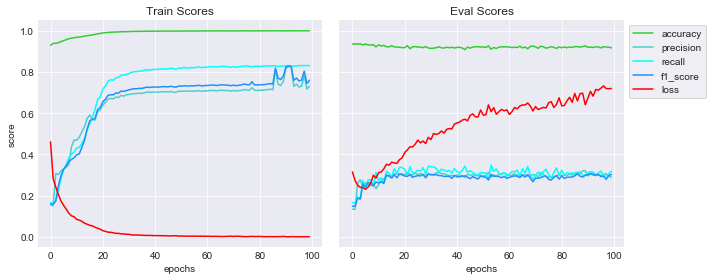

In [69]:
fig = plt.figure(figsize=(10, 4))


plt.subplot(1, 2, 1)
plt.title("Train Scores")
plt.plot(data['performance']['train']['accuracy'], label="accuracy", color="limegreen")
plt.plot(data['performance']['train']['precision'], label="precision", color="mediumturquoise")
plt.plot(data['performance']['train']['recall'], label="recall", color="aqua")
plt.plot(data['performance']['train']['f1_score'], label="f1_score", color="dodgerblue")
plt.plot(data['performance']['train']['loss'], label="loss", color="red")

plt.ylim(-0.05, 1.05)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylabel('score')
plt.xlabel('epochs')

plt.subplot(1, 2, 2)
plt.title("Eval Scores")
plt.plot(data['performance']['eval']['accuracy'], label="accuracy", color="limegreen")
plt.plot(data['performance']['eval']['precision'], label="precision", color="mediumturquoise")
plt.plot(data['performance']['eval']['recall'], label="recall", color="aqua")
plt.plot(data['performance']['eval']['f1_score'], label="f1_score", color="dodgerblue")
plt.plot(data['performance']['eval']['loss'], label="loss", color="red")
plt.legend(frameon=True, bbox_to_anchor=[1, 1])

plt.ylim(-0.05, 1.05)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], " ")
plt.xlabel('epochs')


# Better plots
plt.tight_layout()

plt.savefig('img/scores_BiLSTM.png', dpi=200)

With this example, the training is over fitting the model and evaluation results are diverging.

# Confusion

All confusion matrices are saved in ``data['performance']['train']['confusion']`` (so there are ``EPOCHS`` matrices... for each models !)

It's a lot of data, but the more the better.

Now we can play with all of these, and see the evolution over time etc.

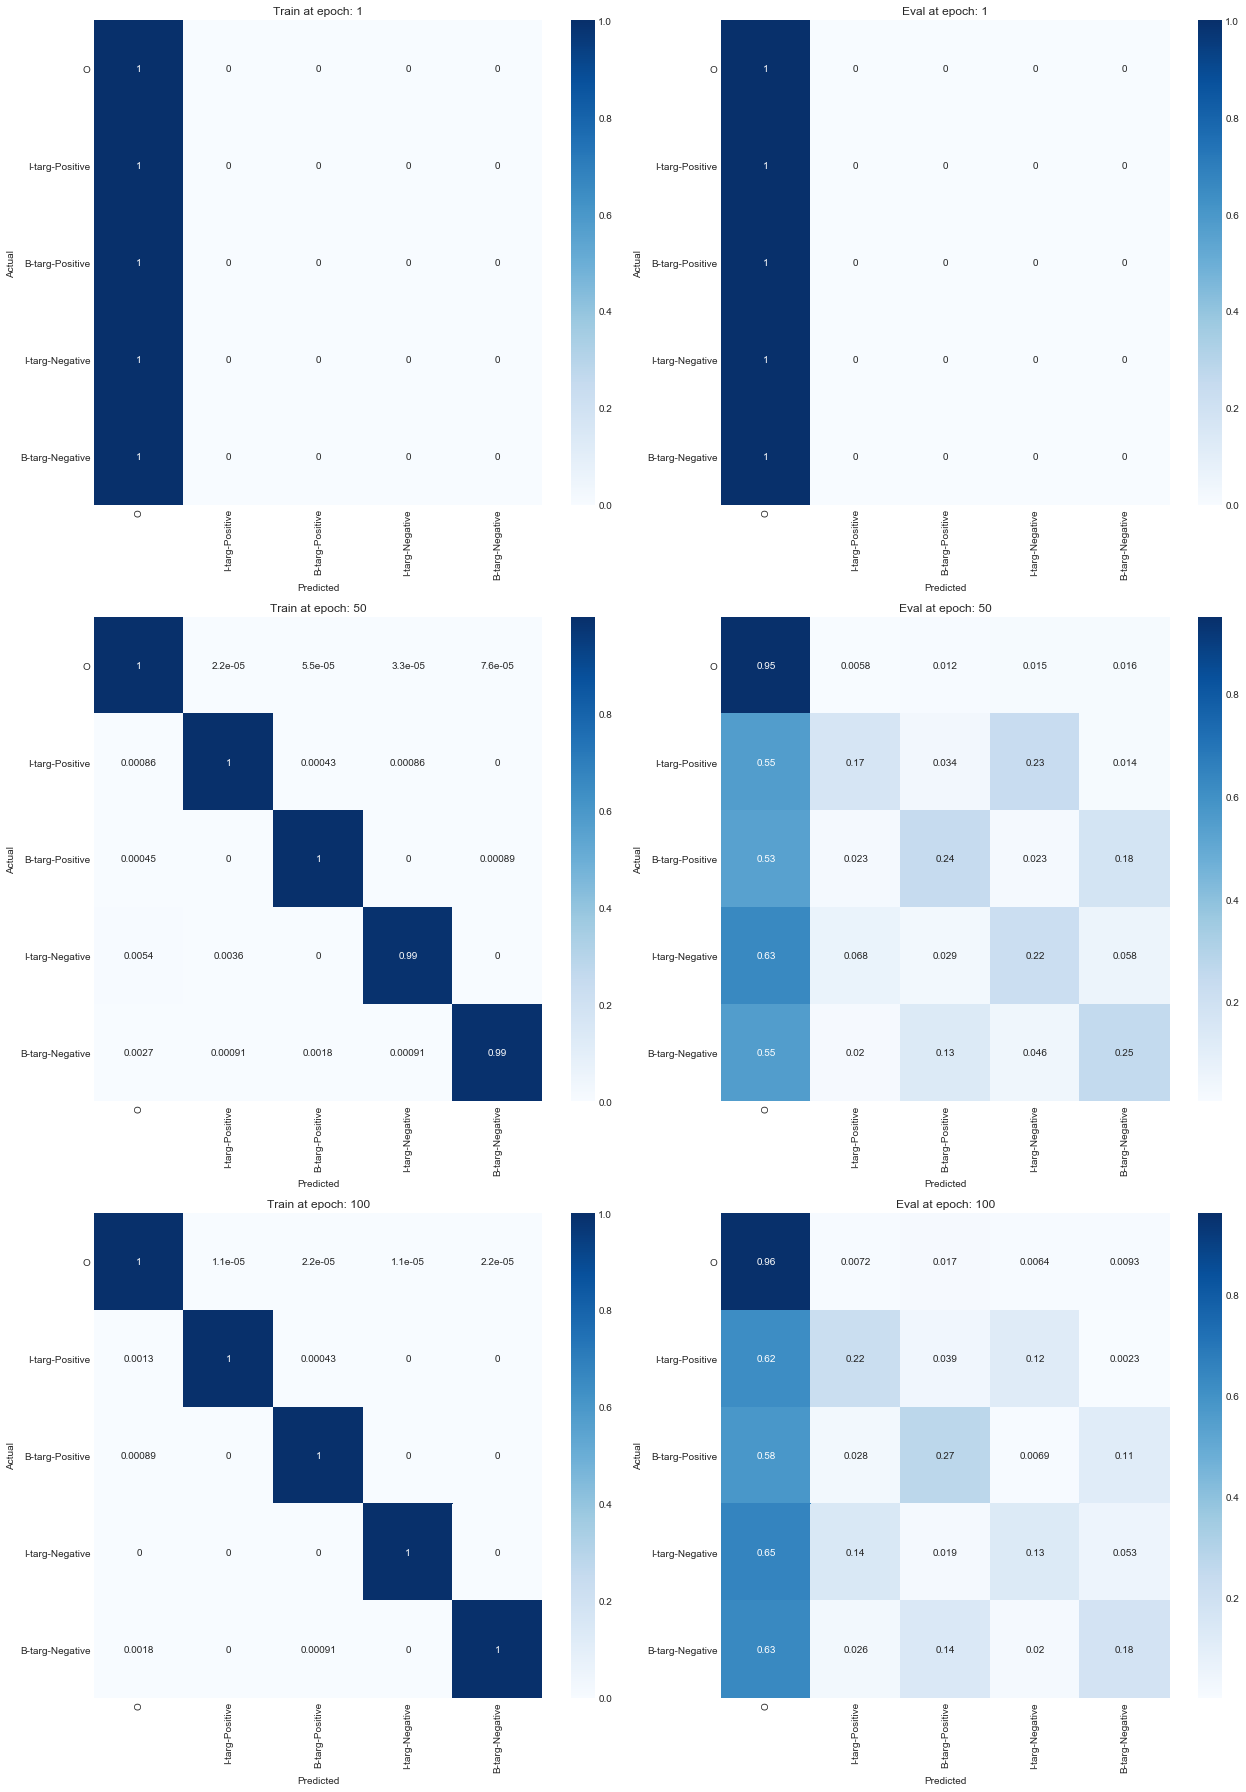

In [23]:
from sentarget.metrics import ConfusionMatrix

fig = plt.figure(figsize=(18, 25))


LABELS = ['<pad>', 'O', 'I-targ-Positive', 'B-targ-Positive', 'I-targ-Negative', 'B-targ-Negative']
NAMES = LABELS[1:]

# Modify this line
EPOCHS = [1, 50, 100]

num_rows = len(EPOCHS)
for i, epoch in enumerate(EPOCHS):
    plt.subplot(num_rows, 2, 2*i + 1)
    mat = data['performance']['train']['confusion'][epoch-1]
    confusion = ConfusionMatrix(data=mat)
    ax = confusion.plot(names=NAMES, normalize=True, cbar=True)
    plt.title(f"Train at epoch: {epoch}")

    plt.subplot(NUMBER_OF_ROWS, 2, 2*i + 2)
    mat = data['performance']['eval']['confusion'][epoch-1]
    confusion = ConfusionMatrix(data=mat)
    ax = confusion.plot(names=NAMES, normalize=True, cbar=True)
    plt.title(f"Eval at epoch: {epoch}")


plt.tight_layout()
plt.show()

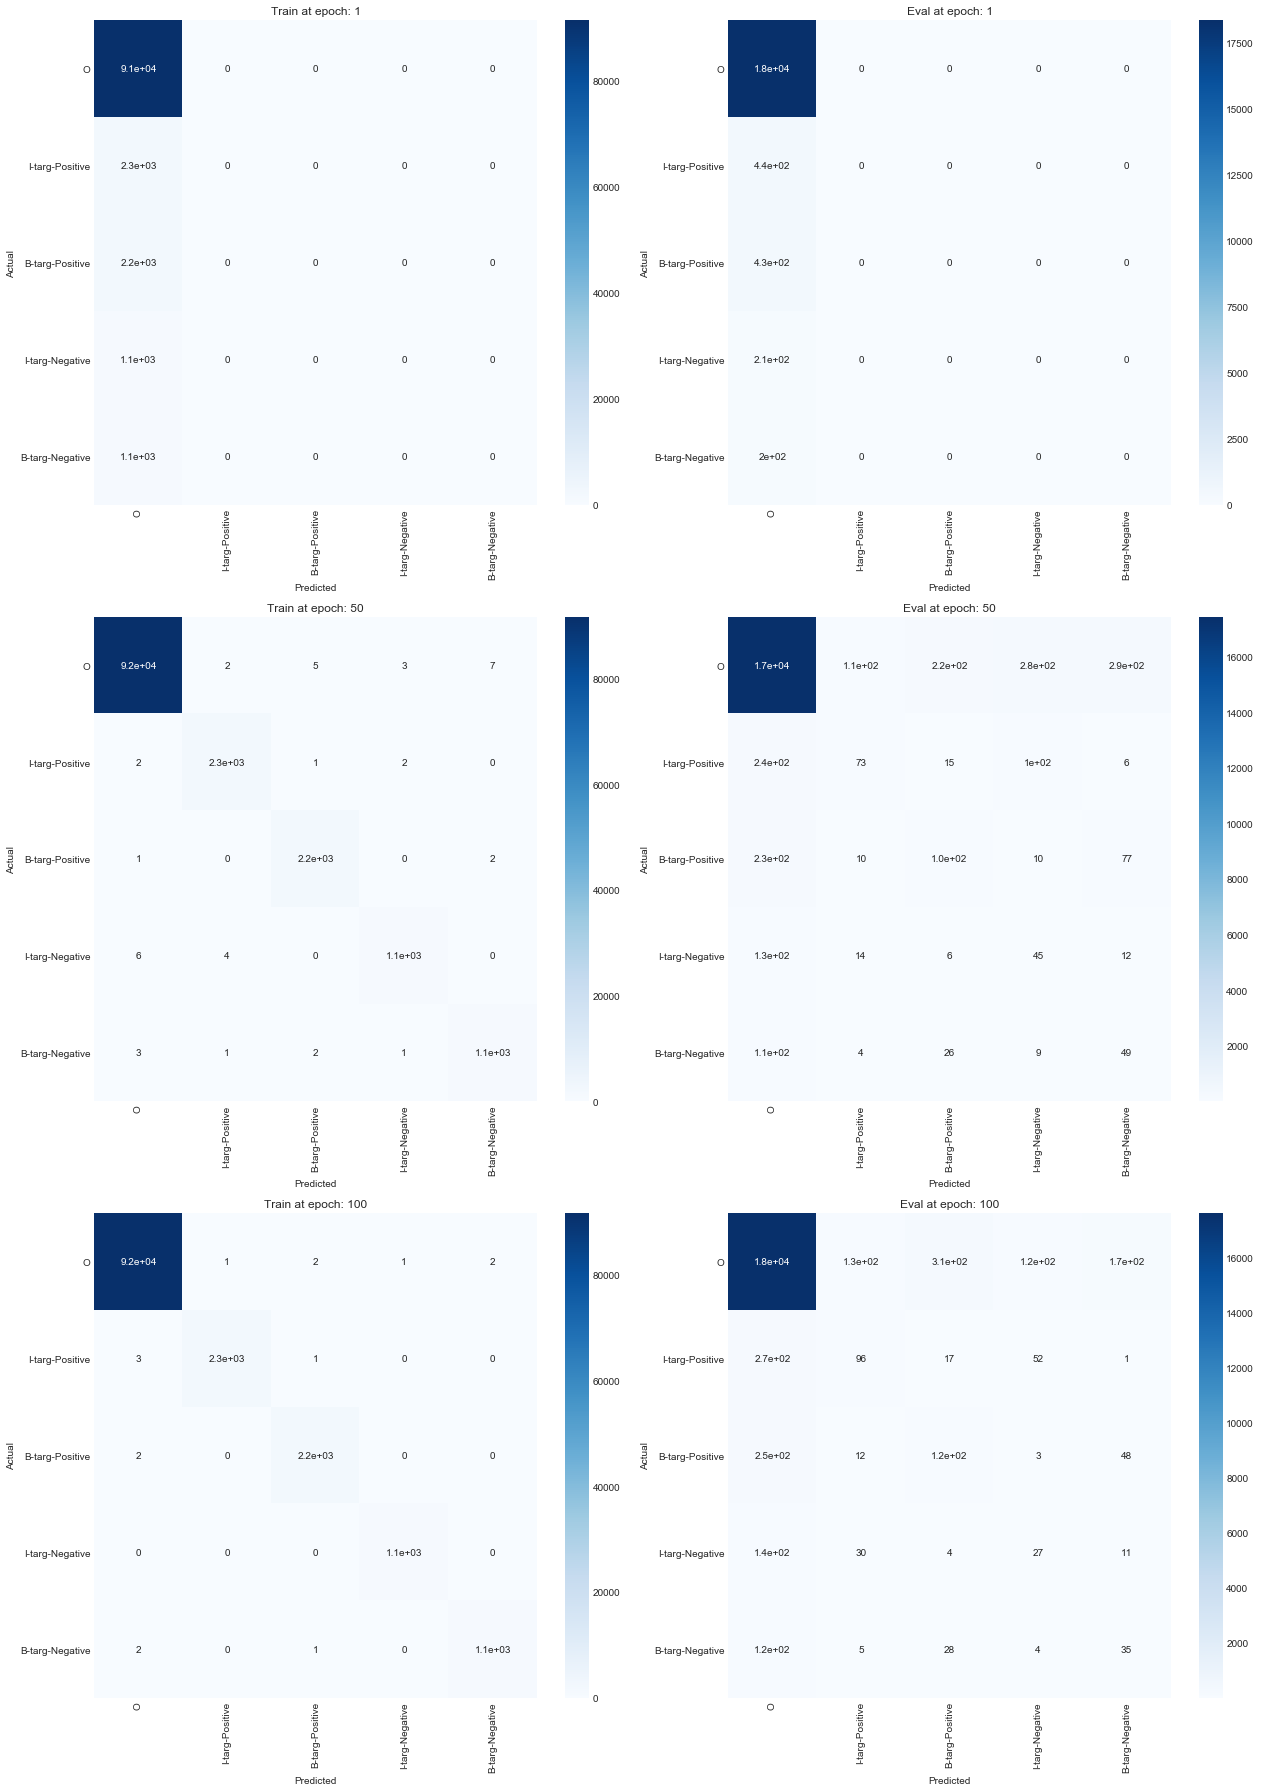

In [24]:
from sentarget.metrics import ConfusionMatrix

fig = plt.figure(figsize=(18, 25))


LABELS = ['<pad>', 'O', 'I-targ-Positive', 'B-targ-Positive', 'I-targ-Negative', 'B-targ-Negative']
NAMES = LABELS[1:]

# Modify this line
EPOCHS = [1, 50, 100]

num_rows = len(EPOCHS)
for i, epoch in enumerate(EPOCHS):
    plt.subplot(num_rows, 2, 2*i + 1)
    mat = data['performance']['train']['confusion'][epoch-1]
    confusion = ConfusionMatrix(data=mat)
    ax = confusion.plot(names=NAMES, normalize=False, cbar=True)
    plt.title(f"Train at epoch: {epoch}")

    plt.subplot(NUMBER_OF_ROWS, 2, 2*i + 2)
    mat = data['performance']['eval']['confusion'][epoch-1]
    confusion = ConfusionMatrix(data=mat)
    ax = confusion.plot(names=NAMES, normalize=False, cbar=True)
    plt.title(f"Eval at epoch: {epoch}")


plt.tight_layout()
plt.show()

# Saving figures

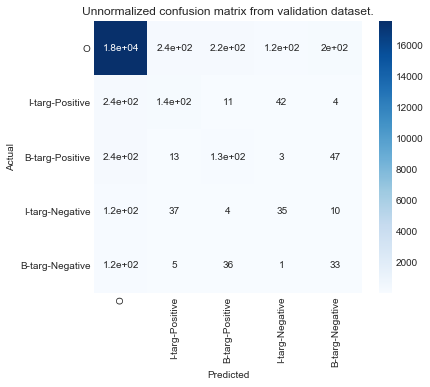

In [70]:
fig = plt.figure(figsize=(6, 5))
mat = data['performance']['eval']['confusion'][99]
confusion = ConfusionMatrix(data=mat)
ax = confusion.plot(names=NAMES, normalize=False, cbar=True)
plt.title(f"Unnormalized confusion matrix from validation dataset.")

plt.savefig(f'img/confusion_imbalance_unnormalized_eval.png', dpi=200, bbox_inches='tight')

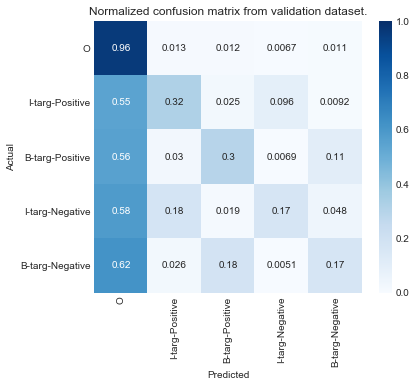

In [71]:
fig = plt.figure(figsize=(6, 5))
mat = data['performance']['eval']['confusion'][99]
confusion = ConfusionMatrix(data=mat)
ax = confusion.plot(names=NAMES, normalize=True, cbar=True, vmin=0, vmax=1)
plt.title(f"Normalized confusion matrix from validation dataset.")

plt.savefig(f'img/confusion_imbalance_normalized_eval.png', dpi=200, bbox_inches='tight')

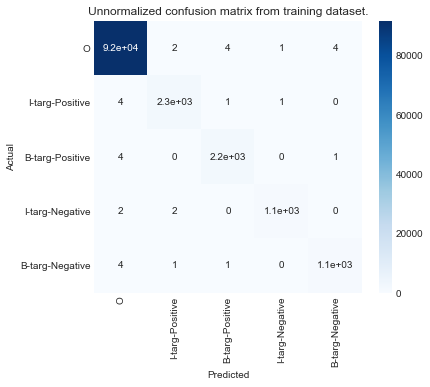

In [72]:
fig = plt.figure(figsize=(6, 5))
mat = data['performance']['train']['confusion'][99]
confusion = ConfusionMatrix(data=mat)
ax = confusion.plot(names=NAMES, normalize=False, cbar=True)
plt.title(f"Unnormalized confusion matrix from training dataset.")

plt.savefig(f'img/confusion_imbalance_unnormalized_train.png', dpi=200, bbox_inches='tight')

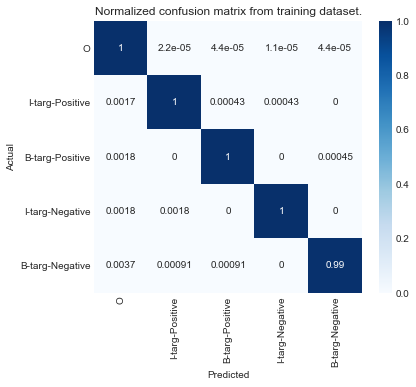

In [73]:
fig = plt.figure(figsize=(6, 5))
mat = data['performance']['train']['confusion'][99]
confusion = ConfusionMatrix(data=mat)
ax = confusion.plot(names=NAMES, normalize=True, cbar=True, vmin=0, vmax=1)
plt.title(f"Normalized confusion matrix from training dataset.")

plt.savefig(f'img/confusion_imbalance_normalized_train.png', dpi=200, bbox_inches='tight')